<div style="background-image:url('../share/images/header.svg'); padding: 0px; background-size:cover; background-opacity:50%; border-radius:5px; height: 250px">
    <div style="float:right; margin: 50px; padding: 20px; background:rgba(255,255,255,0.7); width: 50%; height: 150px">
        <div style="position:relative; top:50%; transform: translateY(-50%)">
            <div style="font-size: xx-large; font-weight:900; color:rgba(0,0,0,0.8); line-height:100%">Rotational Seismology</div>
            <div style="font-size: large; padding-top: 20px; color:rgba(0,0,0,0.5)">Estimate Love Wave Phase-Velocities</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

##### Authors:
* Johannes Salvermoser ([@salve-](https://github.com/salve-))

---

<h1>Rotational Seismology Tutorial: Estimate Phase Velocities</h1>
<br>
**1 Load waveforms**<br>
**2 Calculate correlation coefficients**<br>
**3 Estimate Love wave phase velocities**

![](images/obspy_logo_full_524x179px.png)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 8

### 1 Load pre-processed waveforms and event-xml

Waveforms of transverse acceleration and vertical rotation rate are loaded from the repository. <br>
They were pre-processed as described in the **Data Download + Pre-processing**-Tutorial. <br>
That means they are:
<ul> <li>instrument corrected</li>
<li>resampled</li>
<li>filtered</li>
<li>rotated to radial-transverse </li></ul><br>
We also need the locations of station and event epicenter to obtain the theoretical backazimuth.

In [2]:
from obspy import read, read_events
from obspy.geodetics.base import gps2dist_azimuth
AC = read('data/acc_Tohoku_preproc.mseed')
RLAS = read('data/rot_Tohoku_preproc.mseed')
cat = read_events('data/xml_Tohoku.xml')
event = cat[0]

# event location from event info
source_latitude = event.origins[0].latitude
source_longitude = event.origins[0].longitude

# station location (Wettzell)
station_latitude = 49.144001
station_longitude = 12.8782

# theoretical backazimuth and distance
baz = gps2dist_azimuth(source_latitude, source_longitude, station_latitude, station_longitude)

### 2 Calculate correlation coefficients for time windows
For the phase velocity analysis, the waveforms are divided into sub-windows. Due to the dispersive character of Love waves lower frequency waves are faster and arrive earlier at the measurement station than the higher frequency waves. We calculate phase velocities for subsequent time windows in which different frequencies dominate to catch this dispersive behavior.<br>
<br>
In the first step, for each time window, we need to calculate zero-lag correlation coefficients between the transverse component of acceleration and the vertical rotation rate. The correlation yields the similarity of the two observed waveforms and is used as a threshold for the phase velocity estimation.

/Users/lion/miniconda3/envs/seismo_live/lib/python3.7/site-packages/obspy/signal/cross_correlation.py:220: ObsPyDeprecationWarning: Call to deprecated function xcorr(). Please use the correlate and xcorr_max functions.
  warnings.warn(msg, ObsPyDeprecationWarning)


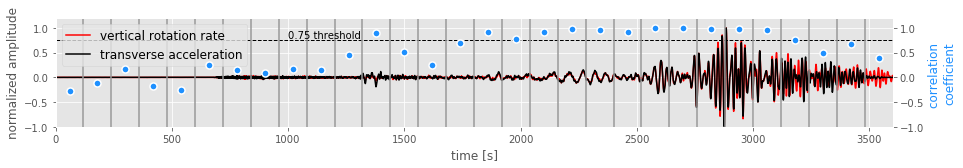

In [3]:
from obspy.signal.cross_correlation import xcorr
import numpy as np

sampling_rate = int(RLAS[0].stats.sampling_rate)
sec = 120  # window length for correlation (teleseismic event)

# calculate correlation coefficients
corrcoefs = []
for ic in range(0, len(RLAS[0]) // (int(sampling_rate * sec))):
        coeffs = xcorr(RLAS[0].data[sampling_rate * sec * ic : sampling_rate * sec * (ic + 1)],
                       AC[0].data[sampling_rate * sec * ic : sampling_rate * sec * (ic + 1)], 0)
        corrcoefs.append(coeffs[1])

# plot waveforms in comparison and correlation coefficients in time windows
plt.figure(figsize=(15,2))
ax=plt.subplot(111)
ax.plot(RLAS[0].times(), RLAS[0].data/np.max(np.abs(RLAS[0].data)), 'r', label='vertical rotation rate')
ax.plot(AC[0].times(), AC[0].data/np.max(np.abs(AC[0].data)), 'k', label='transverse acceleration')
ax.set_xlabel('time [s]')
ax.set_ylabel('normalized amplitude')
ax.set_ylim(-1.0,1.2)
ax.axhline(y=.75, linewidth=1, c='k',ls='dashed')
ax.legend(loc=2, prop={"size":12})
for xi in range(sec,sec * len(corrcoefs)-1, sec):
    ax.axvline(x=xi, color='.6')

ax2=ax.twinx()
ax2.scatter(np.arange(60,sec * len(corrcoefs),sec),corrcoefs,c='Dodgerblue',s=50,edgecolors='w',linewidth=1.5)
ax2.set_xlim(0, RLAS[0].times()[-1])
ax2.set_ylim(-1,1.2)
ax2.set_ylabel('correlation \ncoefficient', color='Dodgerblue')
ax2.annotate('0.75 threshold', xy=(1000,.8),xycoords='data')
ax2.grid(visible=False)

plt.show()

### 3 Estimate Love wave phase velocities
At any time rotation rate and transverse acceleration are in phase and the amplitudes are related by <br><br>
\begin{equation}
    \frac{a_{transv}(x, t)}{\dot{\Omega_z}(x, t)} = −2 \cdot v_{ph}
\end{equation}<br>
The phase velocities can now be estimated by best-fitting waveforms the sliding time-windows along the seismic signal.<br><br>
For a detailed deduction of this relationship, see **<i>Igel et al. [2005]**</i>  (link in References section).<br>

Get theoretical P- and S-Wave first arrivals from a 1D velocity model using **TauPy**:

In [4]:
from obspy.taup import TauPyModel
TauPy_model = TauPyModel('ak135')
arrivals_p = TauPy_model.get_travel_times(distance_in_degree=0.001 * baz[0] / 111.11,
                                        source_depth_in_km=event.origins[0].depth*0.001,
                                       phase_list=["P","p","Pdiff","PP","PKiKP","PKIKP","Pn","Pg"])
arrivals_s = TauPy_model.get_travel_times(distance_in_degree=0.001 * baz[0] / 111.11,
                                        source_depth_in_km=event.origins[0].depth*0.001,
                                       phase_list=["S","s","Sdiff","SS","SKiKS","SKIKS","Sn","Sg"])
tiemp = []
tiems = []
for i in range(0,len(arrivals_p)): tiemp.append(arrivals_p[i].time)
for ii in range(0,len(arrivals_s)): tiems.append(arrivals_s[ii].time)

# first arrivals
arriv_p = min(tiemp)
arriv_s = min(tiems)
print("P-wave arrival: ", arriv_p, "sec")
print("S-wave arrival: ", arriv_s, "sec")

P-wave arrival:  743.918841784 sec
S-wave arrival:  1362.23758331 sec


**Estimate phase velocities**<br>
The Love wave phase velocities are estimated only for time-windows later than S-waves and for a threshold of 75% correlation between transverse acceleration and vertical rotation rate.

In [5]:
sampling_rate = int(RLAS[0].stats.sampling_rate)

# calculate Love wave phase velocities [km/s] for time windows featuring correlation coefficients > 0.75
# and after S-wave arrival
surf = int(arriv_s/120.)+2  # window number after S-waves
phasv = []
for iph in range(surf, len(corrcoefs)):
    if corrcoefs[iph] >= 0.75:
        phas_v = 0.001 * 0.5 * max(AC[0].data[sampling_rate * sec * iph : sampling_rate * sec * (iph + 1)]) /\
                 max(RLAS[0].data[sampling_rate * sec * iph : sampling_rate * sec * (iph + 1)])
    else:
        phas_v = np.NaN
    phasv.append(phas_v)

**Plot phase velocities**

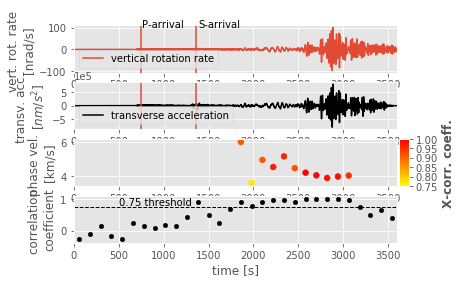

In [6]:
import matplotlib as mpl

plt.subplot2grid((4, 30), (0, 0), colspan=29)
plt.plot(RLAS[0].times(), RLAS[0].data,label='vertical rotation rate')
plt.xlim(0, RLAS[0].times()[-1])
plt.ylabel('vert. rot. rate \n[nrad/s]')
plt.legend(loc=3)

# add P- and S-wave arrivals
plt.axvline(arriv_p);plt.annotate('P-arrival', xy=(arriv_p+20,np.max(RLAS[0].data)),xycoords='data');
plt.axvline(arriv_s);plt.annotate('S-arrival', xy=(arriv_s+20,np.max(RLAS[0].data)),xycoords='data');

# transverse acceleration
plt.subplot2grid((4, 30), (1, 0), colspan=29)
plt.plot(AC[0].times(), AC[0].data, 'k',label='transverse acceleration')
plt.xlim(0, AC[0].times()[-1])
plt.ylabel('transv. acc. \n[$nm/s^2$]')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.legend(loc=3)
plt.axvline(arriv_p)
plt.axvline(arriv_s)

# phase velocities plot
plt.subplot2grid((4, 30), (2, 0), colspan=29)
vel = plt.scatter(np.arange(sec/2. + surf*sec, sec/2. + sec * (len(phasv)+surf), sec), phasv,c=corrcoefs[surf:], vmin=0.75, vmax=1, s=35,cmap=plt.cm.autumn_r)
plt.xlim(0, RLAS[0].stats.delta * len(RLAS[0].data))
plt.ylabel('phase vel. \n[km/s]')
plt.xlabel('time [s]')

# add colorbar
fig = plt.subplot2grid((4, 30), (2, 29))
norm = mpl.colors.Normalize(vmin=.75, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(fig, cmap=plt.cm.autumn_r, norm=norm, orientation='vertical')
cb1.set_ticks([0.75,0.8,0.85,0.9,0.95,1])
cb1.set_label(u'X-corr. coeff.', fontweight='bold')

# correlation coefficients plot
plt.subplot2grid((4, 30), (3, 0), colspan=29)
plt.scatter(np.arange(sec/2., sec/2. + sec * len(corrcoefs), sec), corrcoefs,c='k', s=20)
plt.xlim(0, RLAS[0].stats.delta * len(RLAS[0].data))
plt.xlabel('time [s]')
plt.ylabel('correlation \ncoefficient')
plt.axhline(y=.75, linewidth=1, c='k',ls='dashed')
plt.annotate('0.75 threshold', xy=(500,.8),xycoords='data')

plt.show()

### References
<ul>
    Beyreuther, M., R. Barsch, L. Krischer, T. Megies, Y. Behr and J. Wassermann (2010)<br>
    <a href=http://www.seismosoc.org/Publications/SRL/SRL_81/srl_81-3_es/>ObsPy: A Python Toolbox for Seismology</a> <br>
    SRL, 81(3), 530-533, doi:10.1785/gssrl.81.3.530<br>
    <br>
    Igel, H., U. Schreiber, A. Flaws, B. Schuberth, A. Velicoseltsev, A. Cochard (2005)<br>
    <a href= http://onlinelibrary.wiley.com/doi/10.1029/2004GL022336/full>
    Rotational motions induced by the M8.1 Tokachi-oki earthquake, September 25, 2003</a> <br>
    GRL, doi:10.1029/2004GL022336<br>
    <br>
    Krischer, L., T. Megies, R. Barsch, M. Beyreuther, T. Lecocq, C. Caudron, J. Wassermann (2015)<br>
    <a href=http://iopscience.iop.org/article/10.1088/1749-4699/8/1/014003/meta;jsessionid=429E7836F3590551E4FF9EE94853C476.c5.iopscience.cld.iop.org>
    ObsPy: a bridge for seismology into the scientific Python ecosystem</a><br>
    Computational Science & Discovery, 8(1), 014003, doi:10.1088/1749-4699/8/1/014003<br>
    <br>
    Megies, T., M. Beyreuther, R. Barsch, L. Krischer, J. Wassermann (2011)<br>
    <a href=http://www.annalsofgeophysics.eu/index.php/annals/article/view/4838>
    ObsPy – What can it do for data centers and observatories?</a> <br>
    Annals Of Geophysics, 54(1), 47-58, doi:10.4401/ag-4838
</ul>
